In [47]:
pip install adjustText

   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ------- -------------------------------- 8.1/41.2 MB 42.1 MB/s eta 0:00:01
   ------------------ --------------------- 18.6/41.2 MB 43.6 MB/s eta 0:00:01
   --------------------------- ------------ 28.3/41.2 MB 43.8 MB/s eta 0:00:01
   ------------------------------------- -- 38.5/41.2 MB 45.4 MB/s eta 0:00:01
   ---------------------------------------- 41.2/41.2 MB 41.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [119]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import glob
import contextily as ctx
import geopandas.tools
from adjustText import adjust_text
import random
from shapely.ops import nearest_points
from shapely.geometry import Point
from scipy.spatial import distance
from shapely.geometry import LineString, MultiLineString
from pyproj import CRS
from shapely.ops import transform
import pyproj

In [43]:

# Ruta a carpeta con CSVs
carpeta_csv = Path(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Rutas\Rutas_Raw")

# Cargar y unir shapefiles (provincias y CCAA)

# Provincias
prov_pen = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_Prov\Malla_Peninsula\se89_10_admin_prov_a_x.shp")
prov_can = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_Prov\Malla_Canarias\se89_10_admin_prov_a_y.shp")
provincias = pd.concat([prov_pen, prov_can], ignore_index=True).to_crs("EPSG:4326")

# CCAA
ccaa_pen = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_CCAA\Malla_Peninsula\se89_10_admin_ccaa_a_x.shp")
ccaa_can = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_CCAA\Malla_Canarias\se89_10_admin_ccaa_a_y.shp")
ccaa = pd.concat([ccaa_pen, ccaa_can], ignore_index=True).to_crs("EPSG:4326")

# Puntos de interés
puntos_gdf = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Puntos de Interés\CCNN_PTOSINTERES.shp")
puntos_gdf = puntos_gdf.to_crs(provincias.crs)

In [120]:
import shutil
import os

# Eliminar carpeta si existe
ruta_output = "mapas_rutas"
if os.path.exists(ruta_output):
    shutil.rmtree(ruta_output)
os.makedirs(ruta_output)

PermissionError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'mapas_rutas\\176.png'

In [ ]:
def generar_mapa_ruta(ruta, provincias_gdf, output_dir="mapas_rutas", buffer_ratio=0.04):
    ruta_id = str(ruta["ID_Ruta"])
    geometria_ruta = ruta.geometry

    ruta_gdf = gpd.GeoDataFrame([ruta], geometry=[geometria_ruta], crs=provincias_gdf.crs)

    provincias_intersectadas = gpd.sjoin(provincias_gdf, ruta_gdf, how="inner", predicate="intersects")

    if provincias_intersectadas.empty:
        print(f"No se encontró provincia para la ruta {ruta_id}")
        return

    provincia_geom = provincias_intersectadas.unary_union
    provincia_gdf = gpd.GeoDataFrame(geometry=[provincia_geom], crs=provincias_gdf.crs)

    fig, ax = plt.subplots(figsize=(10, 10))

    bounds = provincia_geom.bounds
    x_min, y_min, x_max, y_max = bounds
    dx = (x_max - x_min) * buffer_ratio
    dy = (y_max - y_min) * buffer_ratio
    ax.set_xlim(x_min - dx, x_max + dx)
    ax.set_ylim(y_min - dy, y_max + dy)

    # Provincia con borde un poco más oscuro
    provincia_gdf.plot(ax=ax, facecolor="none", edgecolor="#3b78b5", linewidth=1.8)

    # Dibujar borde negro más grueso
    for geom in ruta_gdf.geometry:
        if isinstance(geom, LineString):
            xs, ys = geom.xy
            ax.plot(xs, ys, color='black', linewidth=5, zorder=2)
        elif isinstance(geom, MultiLineString):
            for part in geom:
                xs, ys = part.xy
                ax.plot(xs, ys, color='black', linewidth=5, zorder=2)

    # Dibujar línea roja encima
    for geom in ruta_gdf.geometry:
        if isinstance(geom, LineString):
            xs, ys = geom.xy
            ax.plot(xs, ys, color='red', linewidth=3, zorder=3, label="Ruta")
        elif isinstance(geom, MultiLineString):
            for part in geom:
                xs, ys = part.xy
                ax.plot(xs, ys, color='red', linewidth=3, zorder=3, label="Ruta")

    try:
        ctx.add_basemap(
            ax,
            source=ctx.providers.OpenStreetMap.Mapnik,
            zoom=9,
            crs=provincia_gdf.crs.to_string()
        )
    except Exception as e:
        print("No se pudo cargar el mapa base:", e)

    ax.set_title(f"Ruta {ruta_id}", fontsize=14)
    ax.axis("off")
    ax.legend()

    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{ruta_id}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()



In [100]:
def generar_mapa_ruta(ruta, provincias_gdf, puntos_gdf, output_dir="mapas_rutas", buffer_ratio=0.04, max_puntos=5, distancia_minima=0.01):
    ruta_id = str(ruta["ID_Ruta"])
    geometria_ruta = ruta.geometry

    # Convertimos la ruta en GeoDataFrame
    ruta_gdf = gpd.GeoDataFrame([ruta], geometry=[geometria_ruta], crs=provincias_gdf.crs)

    # Obtener provincias intersectadas
    provincias_intersectadas = gpd.sjoin(provincias_gdf, ruta_gdf, how="inner", predicate="intersects")

    if provincias_intersectadas.empty:
        print(f"No se encontró provincia para la ruta {ruta_id}")
        return

    provincia_geom = provincias_intersectadas.unary_union
    provincia_gdf = gpd.GeoDataFrame(geometry=[provincia_geom], crs=provincias_gdf.crs)

    # Filtrar puntos de interés dentro de la provincia
    puntos_en_provincia = gpd.sjoin(puntos_gdf.to_crs(provincia_gdf.crs), provincia_gdf, how="inner", predicate="intersects")

    # Limitar el número de puntos de interés (max_puntos) y evitar aglomeraciones
    puntos_finales = limitar_puntos_interes(puntos_en_provincia, max_puntos, distancia_minima)

    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 10))

    # Enfoque en provincia con un buffer para zoom
    bounds = provincia_geom.bounds
    x_min, y_min, x_max, y_max = bounds
    dx = (x_max - x_min) * buffer_ratio
    dy = (y_max - y_min) * buffer_ratio
    ax.set_xlim(x_min - dx, x_max + dx)
    ax.set_ylim(y_min - dy, y_max + dy)

    # Pintar la provincia resaltada con borde azul oscuro
    provincia_gdf.plot(ax=ax, facecolor="none", edgecolor="darkblue", linewidth=3)

    # Pintar la ruta en rojo y más gruesa
    ruta_gdf.plot(ax=ax, color="red", linewidth=4, label="Ruta")

    # Añadir mapa base de OpenStreetMap con CRS adecuado
    try:
        ctx.add_basemap(
            ax,
            source=ctx.providers.OpenStreetMap.Mapnik,
            zoom=12,  # Ajusta el nivel de zoom
            crs=provincia_gdf.crs.to_string()  # Aseguramos que el CRS sea el correcto
        )
    except Exception as e:
        print("No se pudo cargar el mapa base:", e)

    # Pintar los puntos de interés
    if not puntos_finales.empty:
        colores = ['purple', 'orange', 'green', 'blue', 'yellow']  # Colores para los puntos
        marcadores = ['*', 'o', 'D', 's', 'v']  # Tipos de marcadores

        # Crear una lista con los nombres de los puntos de interés
        nombres_puntos = [f"{row['nombre']}" for _, row in puntos_finales.iterrows()]

        # Mostrar los puntos con diferentes colores y formas
        for idx, (nombre, color, marcador) in enumerate(zip(nombres_puntos, colores, marcadores)):
            punto = puntos_finales.iloc[idx]
            ax.plot(punto.geometry.x, punto.geometry.y, color=color, marker=marcador, markersize=20, label=nombre)

            # Añadir el nombre del punto cerca del símbolo, ajustando la posición del texto
            ax.annotate(
                text=nombre,
                xy=(punto.geometry.x, punto.geometry.y),
                xytext=(5, 5),  # Desplazamiento del texto
                textcoords="offset points",
                fontsize=8,
                color=color,
                verticalalignment="bottom",  # Asegurando que el texto no se superponga con el marcador
                horizontalalignment="left"
            )

    ax.set_title(f"Ruta {ruta_id}", fontsize=14)
    ax.axis("off")
    ax.legend()

    # Crear carpeta si no existe
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{ruta_id}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

def limitar_puntos_interes(puntos_gdf, max_puntos, distancia_minima):
    """
    Limita los puntos de interés que se pueden mostrar en el mapa.
    - max_puntos: máximo número de puntos a mostrar
    - distancia_minima: distancia mínima entre puntos para evitar aglomeraciones
    """
    # Si no hay puntos, retornar vacío
    if puntos_gdf.empty:
        return puntos_gdf

    # Calcular distancias entre puntos
    coords = [(p.geometry.x, p.geometry.y) for _, p in puntos_gdf.iterrows()]
    dist_matrix = distance.cdist(coords, coords)

    # Crear lista de índices a eliminar (puntos demasiado cercanos)
    eliminar_idx = set()
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            if dist_matrix[i, j] < distancia_minima:
                eliminar_idx.add(j)  # eliminar el punto más cercano

    # Seleccionar solo los puntos que no se van a eliminar
    puntos_filtrados = puntos_gdf.drop(index=list(eliminar_idx), errors='ignore')

    # Limitar el número de puntos a max_puntos
    if len(puntos_filtrados) > max_puntos:
        puntos_filtrados = puntos_filtrados.head(max_puntos)

    return puntos_filtrados

Procesando: rutas_Andalucía.csv


C:\Users\maria.b.calvo\AppData\Local\Temp\ipykernel_13632\2748813974.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  provincia_geom = provincias_intersectadas.unary_union
C:\Users\maria.b.calvo\AppData\Local\Temp\ipykernel_13632\2748813974.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  provincia_geom = provincias_intersectadas.unary_union
C:\Users\maria.b.calvo\AppData\Local\Temp\ipykernel_13632\2748813974.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  provincia_geom = provincias_intersectadas.unary_union
C:\Users\maria.b.calvo\AppData\Local\Temp\ipykernel_13632\2748813974.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  provincia_geom = provincias_intersectadas.unary_union


KeyboardInterrupt: 

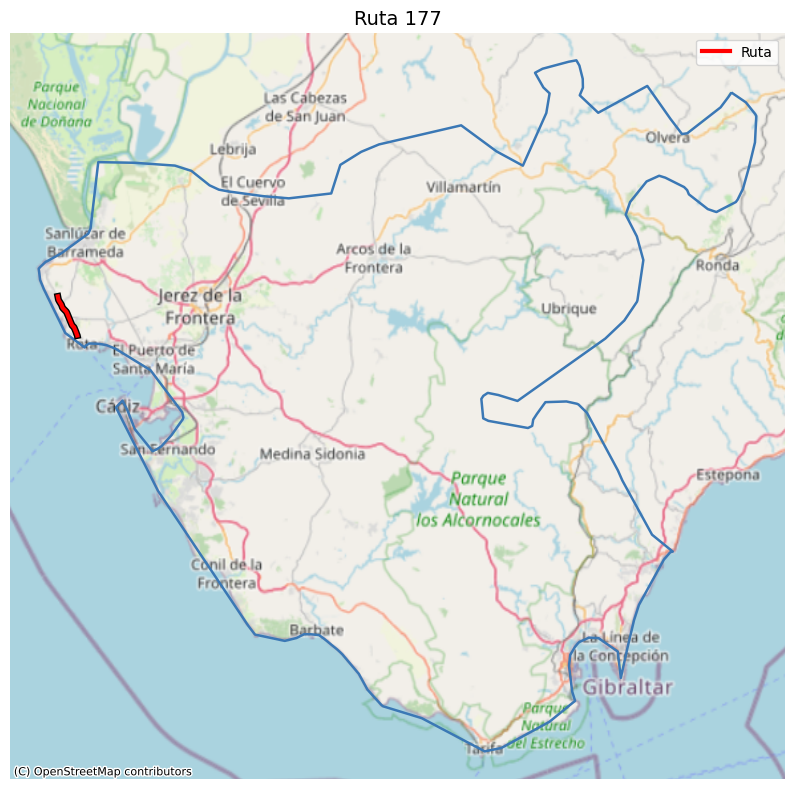

In [118]:
for archivo_csv in carpeta_csv.glob("*.csv"):
    print(f"Procesando: {archivo_csv.name}")
    
    df = pd.read_csv(archivo_csv)
    df["geometry"] = df["geometry"].apply(wkt.loads)
    rutas = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

    for _, ruta in rutas.iterrows():
        generar_mapa_ruta(ruta, provincias)

print("Mapas generados con zoom a cada provincia.")